In [95]:
from typing import Tuple, List
from datetime import datetime, timedelta

import numpy as np

from sgp4.api import Satrec
from sgp4.api import jday

from SATELLITES import SATELLITES
from coordinate_system.EarhRotating import build_default_rotating_cs
from XtoY.cartesianfromgeo import get_cartesian_geo_from_geo_angles
from coordinate_system.earth_models import get_wgs_84
from XtoY.xyz_rfilam import xyz_to_rfilam

from matplotlib import pyplot as plt

In [96]:
def get_satellite_trajectory(tle2lines: Tuple[str, str], time_points: List[datetime]):
    satellite = Satrec.twoline2rv(*tle2lines)
    jd_fr = np.array([jday(*(point.utctimetuple()[:6])) for point in time_points])
    result = [satellite.sgp4(jd, fr)[1] for jd, fr in jd_fr]
    return np.array(result)



s = '1 25338U 98030A   20250.89795419  .00000015  00000-0  25011-4 0  9991'
t = '2 25338  98.7131 275.5172 0010900  31.7666 328.4169 14.25988386160587'

t0 = datetime(2020, 9, 7, 18, 0)
time_points = [t0 + timedelta(seconds=i * 10)  for i in range(1000)]


trajectory = get_satellite_trajectory((s, t), time_points)

print(trajectory)
    


# # широта и долгота ЛК
# lk_coord = [55.930148, 37.518151]
# print("Широта и долгота ЛК", lk_coord)

# # декартовы координты ЛК
# lk_cartesian = get_cartesian_geo_from_geo_angles(latitude=lk_coord[0], longitude=lk_coord[1], model=get_wgs_84())

# print("Декартовы координаты ЛК", lk_cartesian)


# satellite = Satrec.twoline2rv(s, t)

# jd, fr = jday(2020, 9, 9, 14, 00, 0)

# # получаем векторы координат и скорости спутника в конкретный момент времени
# result = satellite.sgp4(jd, fr)

# print("Координаты спутника x, y, z", result[1])
# print("Скорсть спутника v_x, v_y, v_z", result[2])

# # получаем матрицу перехода от ИСО в НеИСО в момент времени data
# data = datetime(2020, 9, 7).timestamp()
# rotator = build_default_rotating_cs()
# rm = rotator.get_matrix(data)

# # координаты в нужной системе отсчета
# result_in_itrs = rm.dot(result[1])
# print("Координаты спутника в НеИСО", result_in_itrs)

# lk_in_itrs = rm.dot(lk_cartesian)
# print("Координаты ЛК в НеИСО в километрах", lk_in_itrs/1000)

[[ -355.43070613 -4510.60875363  5563.8386017 ]
 [ -368.85254885 -4452.92686208  5609.18458012]
 [ -382.23463011 -4394.76497377  5653.92436794]
 ...
 [ 1244.01063375 -1563.94417635 -6909.47149283]
 [ 1249.44800908 -1635.9259258  -6891.71391529]
 [ 1254.75215416 -1707.73323461 -6873.21957876]]


In [97]:
rotator = build_default_rotating_cs()
wgs84 = get_wgs_84()

def get_terrestrial_point_coordinates(geo_angles: Tuple[float, float], time_points: List[datetime]):
    coordinates = get_cartesian_geo_from_geo_angles(latitude=geo_angles[0], longitude=geo_angles[1], model=wgs84)
    time_points_timestamps = [time_point.timestamp() for time_point in time_points]
    rotation_matrix_list = rotator.get_matrix(time_points_timestamps)
    coordinates_in_inertial_system = np.array([rm.dot(coordinates) / 1000 for rm in rotation_matrix_list])
    return coordinates_in_inertial_system

def move_satellite_trajectory_to_earth_coordinates(
    trajectory: np.ndarray, time_points: List[datetime]
):
    time_points_timestamps = [time_point.timestamp() for time_point in time_points]
    rotation_matrix_list = rotator.get_matrix(time_points_timestamps)
    trajectory_in_earth_coordinates = np.array([rm.dot(coordinate) for rm, coordinate in zip(rotation_matrix_list, trajectory)])
    return trajectory_in_earth_coordinates

lk_coord = [55.930148, 37.518151]
lk_coordinate = get_cartesian_geo_from_geo_angles(latitude=lk_coord[0], longitude=lk_coord[1], model=wgs84) / 1000
# lk_coordnates = get_terrestrial_point_coordinates(lk_coord, time_points)
print(lk_coordinate)

earth_sk_trajectory = move_satellite_trajectory_to_earth_coordinates(trajectory, time_points)

print(earth_sk_trajectory)

[ 5111.65560222  -935.24058437 -3685.83437681]
[[ 2693.7022271   3636.47448688  5563.11458798]
 [ 2677.31695595  3578.40784045  5608.43407205]
 [ 2660.55956941  3519.98153009  5653.14744642]
 ...
 [ 1143.48157899  1649.25917869 -6907.00182379]
 [ 1212.20371218  1673.95218521 -6889.23369426]
 [ 1280.83303779  1698.36742786 -6870.7290702 ]]


In [100]:
def get_related_spherical_coordinates(ref_point_coordinate, target_coordinates):
    dr_list = target_coordinates - ref_point_coordinate
    e1 = ref_point_coordinate
    e1 = e1 / np.linalg.norm(e1)
    e2 = np.cross([0, 0, 1], ref_point_coordinate)
    e2 = e2 / np.linalg.norm(e2)
    e3 = np.cross(e1, e2)
    e3 = e3 / np.linalg.norm(e3)
    print(e1, e2, e3)

    coor_e1 = np.dot(dr_list, e1)
    coor_e2 = np.dot(dr_list, e2)
    coor_e3 = np.dot(dr_list, e3)
    length = np.linalg.norm(dr_list, axis=1)
    print(coor_e1)
    
    lam = np.arcsin(coor_e3 / length) * 180 / np.pi
    phi = np.arctan(coor_e2 / coor_e1) * 180 / np.pi
    return phi, lam, coor_e1

phis, lams, coor_e1 = get_related_spherical_coordinates(lk_coordinate, earth_sk_trajectory)

[ 0.80233737 -0.14679754 -0.57853715] [ 0.17997481  0.98367122 -0.        ] [ 0.56909034 -0.10412211  0.81565604]
[ -7961.99142325  -7992.83290275  -8023.56948957  -8054.19838928
  -8084.71678269  -8115.12185541  -8145.41082456  -8175.58088457
  -8205.62923547  -8235.55310809  -8265.34971281  -8295.01626626
  -8324.55001531  -8353.94818848  -8383.20802129  -8412.32677887
  -8441.30171016  -8470.13007177  -8498.80914941  -8527.33621462
  -8555.70854746  -8583.92345635  -8611.97823777  -8639.87019745
  -8667.59666877  -8695.15497538  -8722.54245095  -8749.75645608
  -8776.7943438   -8803.65347799  -8830.33124869  -8856.82504059
  -8883.13225     -8909.25029861  -8935.17660504  -8960.90860024
  -8986.44373576  -9011.77947461  -9036.9132804   -9061.84264483
  -9086.56506103  -9111.07803594  -9135.37909954  -9159.46578555
  -9183.3356422   -9206.98624001  -9230.41515547  -9253.61998031
  -9276.59832773  -9299.3478192   -9321.86609214  -9344.15080462
  -9366.19962524  -9388.01023927  -9409.5

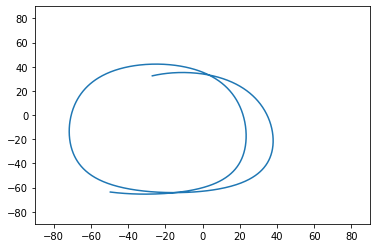

[ -7961.99142325  -7992.83290275  -8023.56948957  -8054.19838928
  -8084.71678269  -8115.12185541  -8145.41082456  -8175.58088457
  -8205.62923547  -8235.55310809  -8265.34971281  -8295.01626626
  -8324.55001531  -8353.94818848  -8383.20802129  -8412.32677887
  -8441.30171016  -8470.13007177  -8498.80914941  -8527.33621462
  -8555.70854746  -8583.92345635  -8611.97823777  -8639.87019745
  -8667.59666877  -8695.15497538  -8722.54245095  -8749.75645608
  -8776.7943438   -8803.65347799  -8830.33124869  -8856.82504059
  -8883.13225     -8909.25029861  -8935.17660504  -8960.90860024
  -8986.44373576  -9011.77947461  -9036.9132804   -9061.84264483
  -9086.56506103  -9111.07803594  -9135.37909954  -9159.46578555
  -9183.3356422   -9206.98624001  -9230.41515547  -9253.61998031
  -9276.59832773  -9299.3478192   -9321.86609214  -9344.15080462
  -9366.19962524  -9388.01023927  -9409.58035184  -9430.90768082
  -9451.9899615   -9472.82494819  -9493.41041017  -9513.74413492
  -9533.82392802  -9553.6

In [99]:
plt.xlim(-90, 90)
plt.ylim(-90, 90)
plt.plot(phis, lams)
plt.show()

print(coor_e1)